前回までのコード(データ作成)

[[-0.93310809 -1.91782868]
 [-2.82859015  0.81086099]
 [-2.75637984 -2.77326179]
 ..., 
 [-0.19083697  0.88233054]
 [ 2.62935019  2.49025702]
 [ 1.44053531  1.59495437]]
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


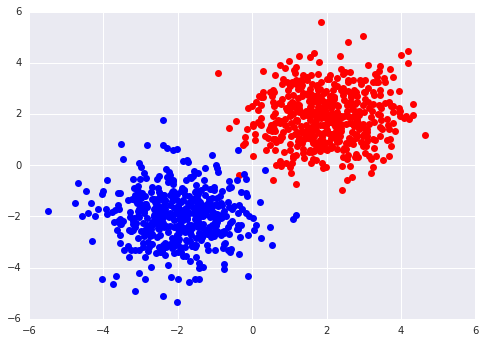

In [222]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x_positive = np.random.randn(500, 1) + 2
y_positive = np.random.randn(500, 1) + 2
x_negative = np.random.randn(500, 1) - 2
y_negative = np.random.randn(500, 1) - 2

plt.figure(1)
plt.plot(x_positive, y_positive, 'ro', label='Data1')
plt.plot(x_negative, y_negative, 'bo', label='Data2')

N = len(x_positive)
POSITIVE = np.zeros((N,2))
for i in xrange(N):
  POSITIVE[i][0] = x_positive[i]
  POSITIVE[i][1] = y_positive[i]

NEGATIVE = np.zeros((N,2))
for i in xrange(N):
  NEGATIVE[i][0] = x_negative[i]
  NEGATIVE[i][1] = y_negative[i]

VIRUS = np.vstack([NEGATIVE, POSITIVE]).astype(np.float32)

print VIRUS

STATE = np.zeros((N*2,2), dtype=np.float32)
for i in xrange(N*2):
  if i < N:
    STATE[i][1] = 1
  else:
    STATE[i][0] = 1

print STATE

TensorFlow処理

In [223]:

def showGraph():
  for operation in tf.get_default_graph().get_operations():
    for output in operation.outputs:
      print "op_name = %s, output_name = %s" %(operation.name, output.name)


tf.reset_default_graph()
LOG_DIR = "./data_virus/"
_w = ""
_b = ""
g_1 = tf.Graph()
with g_1.as_default():

  x = tf.placeholder(tf.float32, shape=(None,2))
  y = tf.placeholder(tf.float32, shape=(None,2))
  w = tf.Variable(tf.random_normal([2,2], stddev=0.01), dtype=tf.float32, name="weight")
  b = tf.Variable(tf.random_normal([2], stddev=0.01), dtype=tf.float32, name="bias")

  # ロジスティック回帰のモデルを定義
  y_pred = tf.nn.softmax(tf.matmul(x,w) + b, name="forward")

  # コストの計算
  loss = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_pred, name="entropy")
  cost = tf.reduce_mean(loss, 0, name="reduce")

  # 精度の計算
  correct_pred = tf.equal(tf.argmax(y_pred,1), tf.argmax(STATE,1))
  accuracy_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

  # 予測
  predict_op = tf.argmax(y_pred, 1, name="predict_op")

  # TensorBoardへの反映
  w_graph = tf.summary.histogram("W_graph", w)
  b_graph = tf.summary.histogram("b_graph", b)
  y_graph = tf.summary.histogram("y_graph", y)
  cost_graph = tf.summary.scalar("cost_graph", cost)

  # 学習済みモデルの保存準備
  saver = tf.train.Saver()

  # トレーニング
  learning_rate = 0.01
  train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

  # Summary
  summary_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
  summary_op = tf.summary.merge_all()

  with tf.Session() as sess:
    
    print("initialization")
    # 初期化処理
    init_op = tf.global_variables_initializer()
    sess.run(init_op)  
  
    # トレーニング回数
    training_step = 1001
    validation_step = 100

    # トレーニング
    for step in xrange(training_step):
      sess.run(train_op, feed_dict={x: VIRUS, y: STATE})

      if step % validation_step == 0:
        accuracy_output,cost_output = sess.run([accuracy_op,cost], feed_dict={x: VIRUS, y: STATE})
        print "step %d, cost %f, accuracy %f" % (step,cost_output,accuracy_output)

        # TensorBoardにも反映
        summary_str = sess.run(summary_op, feed_dict={x: VIRUS, y: STATE})
        summary_writer.add_summary(summary_str, step)

        # 学習済みモデルの保存　ファイル名：checkpointとvirus-model-100.[data-00000-of-00001|index|meta] (step=100の場合)が作られる
        #saver.save(sess, "trained-virus", global_step=step)

    summary_writer.flush()
  
    # Store variable
    _w = w.eval(sess)
    _b = b.eval(sess)

    # check anser
    data = [[-2,-2]]
    x_check = np.array(data)
    flag_pos = sess.run(predict_op, feed_dict={x: x_check})
    print "flag position is %d" % (flag_pos)
    data = [[2,2]]
    x_check = np.array(data)
    flag_pos = sess.run(predict_op, feed_dict={x: x_check})
    print "flag position is %d" % (flag_pos)

sess.close()

initialization
step 0, cost 0.679459, accuracy 0.973000
step 100, cost 0.402448, accuracy 0.996000
step 200, cost 0.368173, accuracy 0.996000
step 300, cost 0.354790, accuracy 0.996000
step 400, cost 0.347494, accuracy 0.996000
step 500, cost 0.342836, accuracy 0.996000
step 600, cost 0.339573, accuracy 0.996000
step 700, cost 0.337142, accuracy 0.996000
step 800, cost 0.335252, accuracy 0.996000
step 900, cost 0.333735, accuracy 0.997000
step 1000, cost 0.332485, accuracy 0.997000
flag position is 1
flag position is 0


In [107]:
!rm model-virus.pb

In [225]:
g_2 = tf.Graph()
with g_2.as_default():
    
  x_2 = tf.placeholder(tf.float32, shape=(None,2), name="input")
  y_2 = tf.placeholder(tf.float32, shape=(None,2))
  w_2 = tf.constant(_w, shape=(2,2), dtype=tf.float32, name="constant_w")
  b_2 = tf.constant(_b, shape=[2], dtype=tf.float32, name="constant_b")
  
  print y_2.dtype
  with tf.Session() as sess_2:
    init_op2 = tf.global_variables_initializer()
    sess_2.run(init_op2)  

    # ロジスティック回帰のモデルを定義
    y_pred2 = tf.nn.softmax(tf.matmul(x_2,w_2) + b_2, name="output")
    print y_pred2.dtype
    # 予測
    predict_op200 = tf.cast(tf.argmax(y_pred2, 1), tf.float32, name="predict_op200")
   
    
    # Add Operation(Test)
    add_op = tf.add(x_2,x_2, name="add_op")
    print sess_2.run(add_op,feed_dict={x_2: x_check2})

    # check anser
    data2 = [[-2.0,-2.0]]
    x_check2 = np.array(data2)
    flag_pos2 = sess_2.run(predict_op200, feed_dict={x_2: x_check2})
    print "flag position is %d" % (flag_pos2)
    data2 = [[2.0,2.0]]
    x_check2 = np.array(data2)
    flag_pos2 = sess_2.run(predict_op200, feed_dict={x_2: x_check2})
    print "flag position is %d" % (flag_pos2)
    
  graph_def = g_2.as_graph_def()
  tf.train.write_graph(graph_def, './', 'graph-virus.pb', as_text=False)
  tf.train.write_graph(graph_def, './', 'graph-virus.pbtxt', as_text=True)
    
sess_2.close()

<dtype: 'float32'>
<dtype: 'float32'>
[[ 4.  4.]]
flag position is 1
flag position is 0
